# This Notebook is to Create the Data Model


In [2]:
import pandas as pd

# Step 1: Load datasets
forecast_df = pd.read_csv("Clean_6h_Forecast.csv")
observation_df = pd.read_csv("noon_solar_readings.csv")

# Step 2: Convert forecast 'Day' to datetime and then to day of year
forecast_df["Day"] = pd.to_datetime(forecast_df["Day"])
forecast_df["DayOfYear"] = forecast_df["Day"].dt.dayofyear

# Step 3: Convert observation 'Day' to datetime and then to day of year
observation_df["Date"] = pd.to_datetime(observation_df["Date"].astype(str), format="%Y%m%d")
observation_df["DayOfYear"] = observation_df["Date"].dt.dayofyear

# Step 4: Merge both dataframes on DayOfYear
combined_df = pd.merge(forecast_df, observation_df, on="DayOfYear", suffixes=('_forecast', '_observation'))

# Optional: drop the original 'Day' columns if no longer needed
#combined_df.drop(columns=["Day_forecast", "Day_observation"], inplace=True)

combined_df.drop(columns = ['Day', 'Date'], inplace=True)

# Select and reorder the desired columns
final_df = combined_df[[
    "DayOfYear",          # Forecast day in day-of-year format
    "Temperature",        # From forecast
    "DewPoint",           # From forecast
    "WindSpeed",          # From forecast
    "SkyCover",           # From forecast (in original or % format)
    "Precipitation",       # From forecast
    "Solar"
]]

# Rename DayOfYear to Day
final_df.rename(columns={"DayOfYear": "Day"}, inplace=True)

# Display the final cleaned dataset
final_df



,Day,Temperature,DewPoint,WindSpeed,SkyCover,Precipitation,Solar
0,1,28,25,1,100,16.766563,29.900
1,2,30,23,10,100,16.766563,29.574
2,3,17,4,15,100,16.766563,29.359
3,4,21,11,9,40,16.766563,29.639
4,5,20,10,7,100,16.766563,29.698
...,...,...,...,...,...,...,...
259,300,68,65,6,100,16.766563,29.891
260,301,51,49,1,100,16.766563,29.817
261,302,42,37,2,80,16.766563,29.946
262,303,34,29,3,40,16.766563,29.982


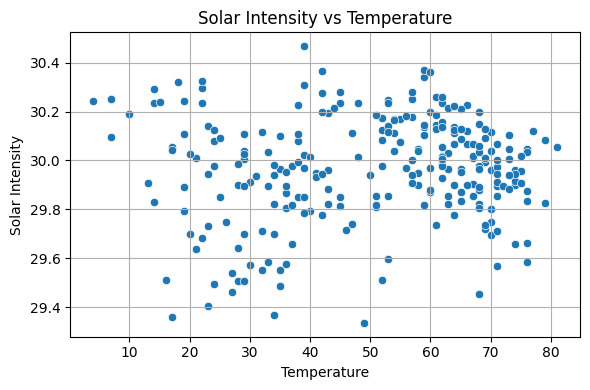

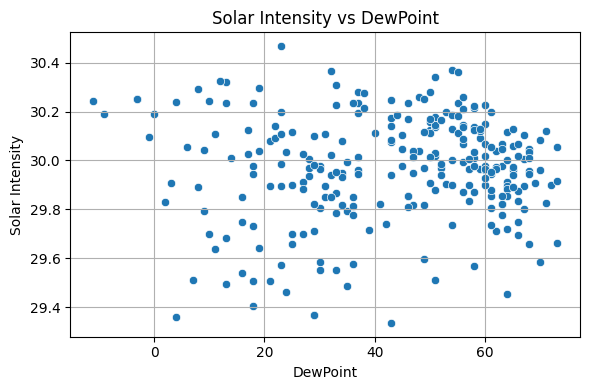

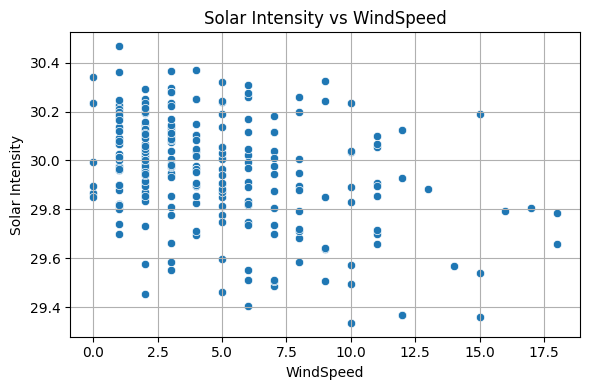

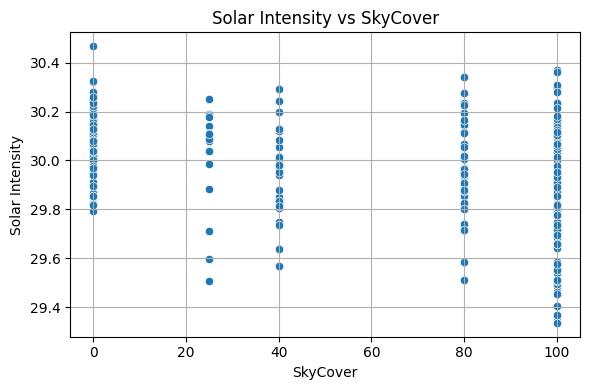

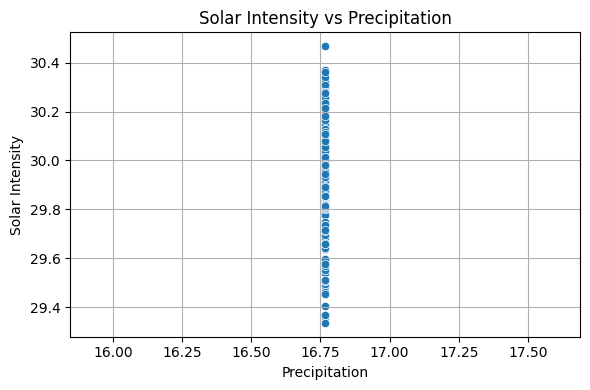

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define label and feature columns
label_column = "Solar" 
feature_columns = ["Temperature", "DewPoint", "WindSpeed", "SkyCover", "Precipitation"]

# Plot scatter plots
for feature in feature_columns:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=combined_df, x=feature, y=label_column)
    plt.title(f"Solar Intensity vs {feature}")
    plt.xlabel(feature)
    plt.ylabel("Solar Intensity")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [4]:
#Drop precipitation Low Variance may cause overfitting
combined_df.drop(columns = ['Precipitation'], inplace=True)

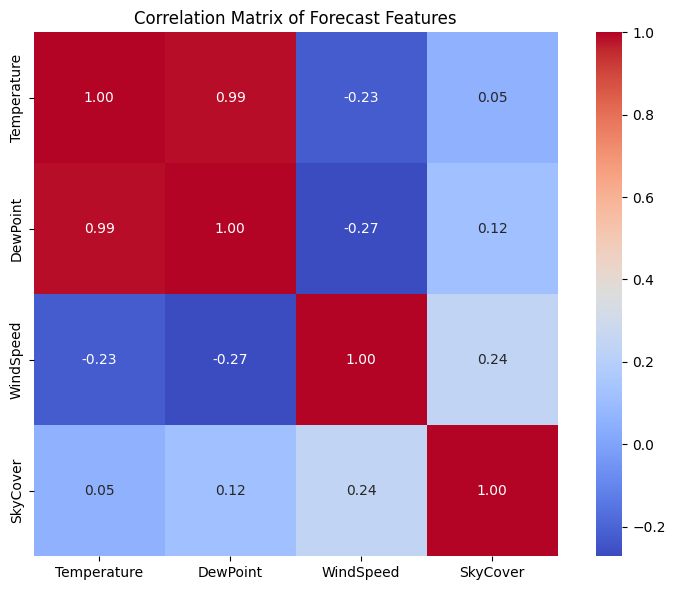

In [5]:
# Compute correlation matrix between only forecast features (excluding the label)
feature_columns = ["Temperature", "DewPoint", "WindSpeed", "SkyCover"]
corr_matrix = combined_df[feature_columns].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix of Forecast Features")
plt.tight_layout()
plt.show()


"However, before applying any regression techniques below we normalize all feature data to have
zero mean and unit variance."

A. Linear Least Squares Regression

SolarIntensity = 1.18*Day + 77.9*Temp + 33.11*DewPoint +
22.8*WindSpeed - 96.9*SkyCover - 49.15*Precipitation - 43.4*Humidity

Cross-Validation RMSE (Training data) in watts/m²: 0.04
Testing RMSE in watts/m²: 0.07


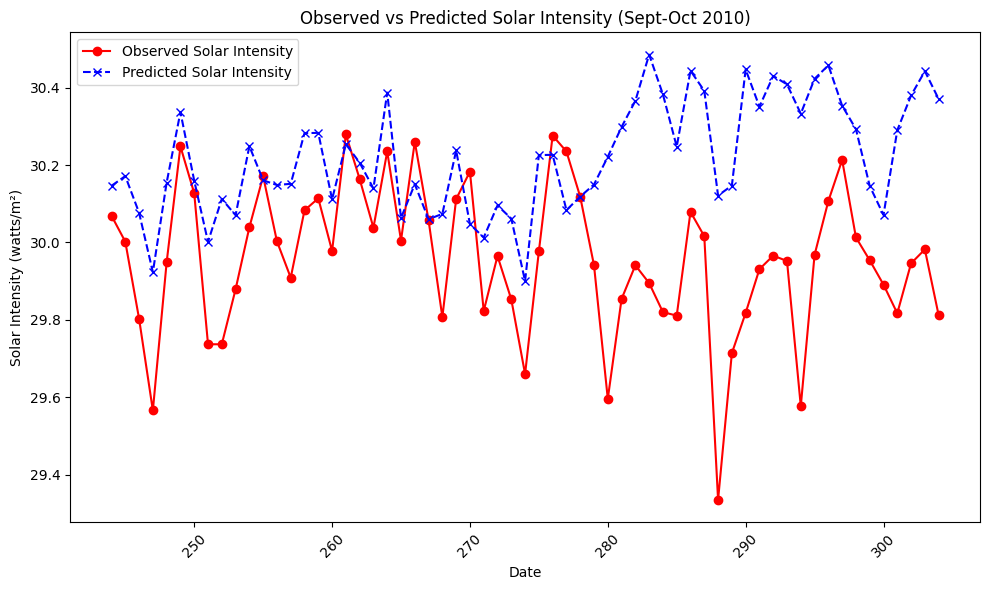

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Step 1: Define the features and target
features = ["Day", "Temperature", "DewPoint", "WindSpeed", "SkyCover"]
target = "Solar"  # Target variable is Solar intensity

# Assuming 'final_df' is the dataframe with your data
# Split the dataset into training and testing sets (Jan-Aug for training, Sept-Oct for testing)
train_df = final_df[final_df['Day'] <= 243]  # Training data (Jan-Aug, days 1-243)
test_df = final_df[final_df['Day'] > 243]  # Testing data (Sept-Dec, days 244-365)

# Step 2: Prepare the feature set and target for both training and testing data
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# Step 3: Standardize the data (zero mean, unit variance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train the Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Step 5: Cross-Validation RMS-Error (on training data)
cv_rmse = np.sqrt(-cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')).mean()

# Step 6: Predict Solar intensity on the training and testing data
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

# Step 7: Calculate RMSE for both the training and testing datasets
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Calculate the standard deviation of the target variable (Solar) in original units (watts/m²)
std_solar = y_train.std()

# Unscale the RMSE to the original units (watts/m²)
test_rmse_watts = test_rmse * std_solar
cv_rmse_watts = cv_rmse * std_solar

# Print RMSE in watts/m²
print(f"Cross-Validation RMSE (Training data) in watts/m²: {cv_rmse_watts:.2f}")
print(f"Testing RMSE in watts/m²: {test_rmse_watts:.2f}")

# Step 8: Plot observed vs. predicted solar intensity for the testing data
plt.figure(figsize=(10, 6))
plt.plot(test_df['Day'], y_test, label="Observed Solar Intensity", color='red', linestyle='-', marker='o')
plt.plot(test_df['Day'], y_test_pred, label="Predicted Solar Intensity", color='blue', linestyle='--', marker='x')
plt.xlabel("Date")
plt.ylabel("Solar Intensity (watts/m²)")
plt.title("Observed vs Predicted Solar Intensity (Sept-Oct 2010)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


B. Support Vector Machines

Cross-Validation RMSE (Training data): 0.30 watts/m²
Training RMSE: 0.17 watts/m²
Testing RMSE: 0.56 watts/m²


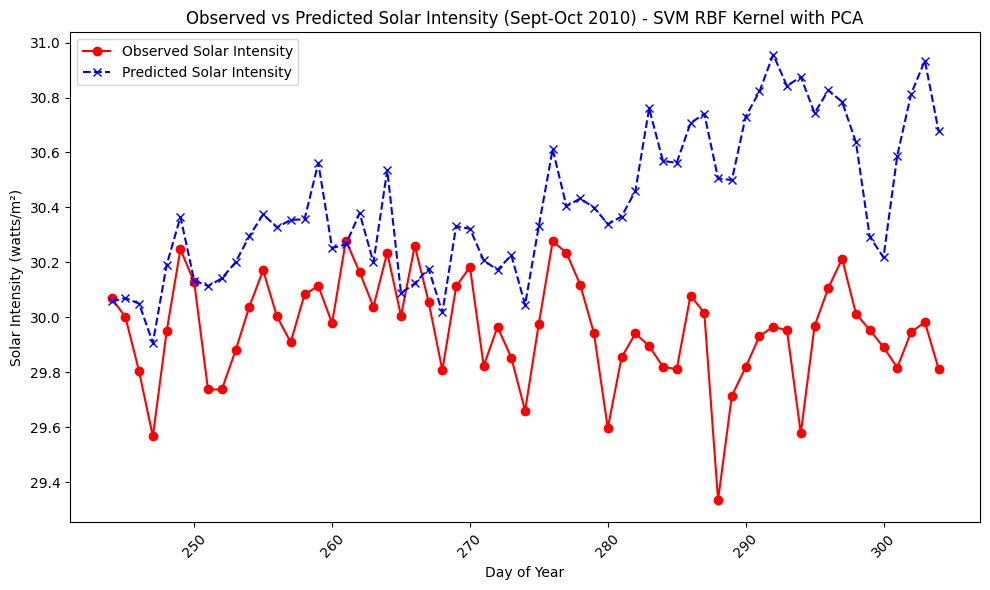

In [7]:
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Step 1: Define the features and target
features = ["Day", "Temperature", "DewPoint", "WindSpeed", "SkyCover"]
target = "Solar"  # Target variable is Solar intensity

# Assuming 'final_df' is the dataframe with your data
# Split the dataset into training and testing sets based on 'Day'
train_df = final_df[final_df['Day'] <= 243]  # Training data (Jan-Aug, days 1-243)
test_df = final_df[final_df['Day'] > 243]  # Testing data (Sept-Dec, days 244-365)

# Step 2: Prepare the feature set and target for both training and testing data
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# Step 3: Standardize the data (zero mean, unit variance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Apply PCA to reduce dimensionality to 4 components
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Step 5: Define the SVM model with RBF kernel and set hyperparameters
svm_model = SVR(C=256, gamma=0.015625, epsilon=0.001953125, kernel='rbf')

# Step 6: Train the SVM model on the PCA-reduced data
svm_model.fit(X_train_pca, y_train)

# Step 7: Cross-Validation RMSE (on training data)
cv_rmse = np.sqrt(-cross_val_score(svm_model, X_train_pca, y_train, cv=5, scoring='neg_mean_squared_error')).mean()
print(f"Cross-Validation RMSE (Training data): {cv_rmse:.2f} watts/m²")

# Step 8: Predict Solar intensity on the training and testing data
y_train_pred = svm_model.predict(X_train_pca)
y_test_pred = svm_model.predict(X_test_pca)

# Step 9: Calculate RMSE for both the training and testing datasets
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training RMSE: {train_rmse:.2f} watts/m²")
print(f"Testing RMSE: {test_rmse:.2f} watts/m²")

# Step 10: Plot observed vs. predicted solar intensity for the testing data
plt.figure(figsize=(10, 6))
plt.plot(test_df['Day'], y_test, label="Observed Solar Intensity", color='red', linestyle='-', marker='o')
plt.plot(test_df['Day'], y_test_pred, label="Predicted Solar Intensity", color='blue', linestyle='--', marker='x')
plt.xlabel("Day of Year")
plt.ylabel("Solar Intensity (watts/m²)")
plt.title("Observed vs Predicted Solar Intensity (Sept-Oct 2010) - SVM RBF Kernel with PCA")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Implement Model Other than Paper: Random Forest

Random Forest - Train RMSE: 0.06 watts/m²
Random Forest - Test RMSE: 0.24 watts/m²


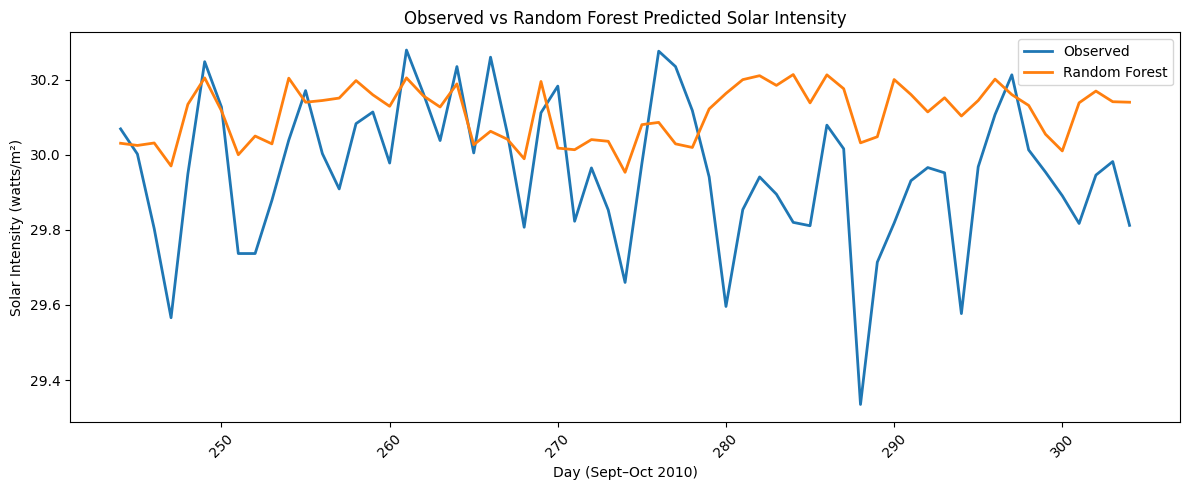

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# 1. Define your feature columns and target
features = ["Day", "Temperature", "DewPoint", "WindSpeed", "SkyCover"]
target = "Solar"

# 2. Split into train/test based on your date logic
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# 3. Fit the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 4. Predict on train and test sets
train_preds = rf_model.predict(X_train)
test_preds = rf_model.predict(X_test)

# 5. Compute RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

print(f"Random Forest - Train RMSE: {train_rmse:.2f} watts/m²")
print(f"Random Forest - Test RMSE: {test_rmse:.2f} watts/m²")

# 6. Plot observed vs predicted for September–October
plt.figure(figsize=(12, 5))
plt.plot(test_df["Day"].values, y_test.values, label="Observed", linewidth=2)
plt.plot(test_df["Day"].values, test_preds, label="Random Forest", linewidth=2)
plt.xlabel("Day (Sept–Oct 2010)")
plt.ylabel("Solar Intensity (watts/m²)")
plt.title("Observed vs Random Forest Predicted Solar Intensity")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
